### 1. Importación de Librerías y Carga de Datos

In [2]:
# ╔══════════════════════╗
# ║  CARGA DE LIBRERIAS  ║
# ╚══════════════════════╝
import time
import random
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [4]:
# ╔═══════════════════╗
# ║  Configuraciones  ║
# ╚═══════════════════╝
CONFIG = {
    'pop_size': 100,
    'gens': 500,
    'pm': 0.2,
    'n_runs': 10,
    'seed_base': 12345,
}

In [3]:
# ╔══════════════════╗
# ║  CARGA DE EXCEL  ║
# ╚══════════════════╝
df = pd.read_excel('data/Candidatos_supermercados.xlsx')
df.columns = [c.strip() for c in df.columns]

display(df.head())

,ID,Descripcion,Latitud,Longitud,Poblacion500m,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Punto 1,Esq. Benavides con Nicolas Dueñas,-12.04861,-77.06496,16500,8.25,0.825,1696.978053,100000.00000
1,Ponto 2,Sta Bernardita con Republica de Venezuela,-12.05956,-77.07583,18000,9.00,0.900,NaN,0.01697
2,Ponto 3,Santa Susana con Santa Gertrudis,-12.06524,-77.07334,17000,8.50,0.850,NaN,NaN
3,Ponto 4,Belizario Sosa Pelaez,-12.05998,-77.06300,15000,7.50,0.750,NaN,NaN
4,Ponto 5,Esq. Aurelio Garcia y Miranono Arredondo,-12.05541,-77.07497,17100,8.55,0.855,NaN,NaN


In [ ]:
# ╔═══════════════════════╗
# ║  EXTRACCIÓN DE DATOS  ║
# ╚═══════════════════════╝
coords = df[['Latitud', 'Longitud']].values            # lat, lon
pop        = df['Poblacion500m'].values                # población
ids        = df['ID'].values                           # Punto 1,2,3,…
desc       = df['Descripcion'].values                  # textp

In [11]:
# ╔══════════════════════════════════╗
# ║  MATRIZ DE DISTANCIAS HAVERSINE  ║
# ╚══════════════════════════════════╝
n = len(df)
D = squareform(
    pdist(coords, lambda u, v: haversine(u, v, unit=Unit.METERS))
)

print(f"Cargados {n} candidatos; matriz de distancias calculada.")

Cargados 60 candidatos; matriz de distancias calculada.


### 2. Clase Individual (OX + swap)

In [12]:
class Individual:
    def __init__(self, chromosome):
        self.chromosome = chromosome[:]
        self.fitness = None
        
    # ---------- Order Crossover (OX) ----------
    def crossover(self, other):
        a, b = sorted(np.random.choice(10, 2, replace=False))
        # Order Crossover (OX)
        def ox(p1, p2):
            child = [None]*10
            child[a:b] = p1[a:b]
            fill = [g for g in p2 if g not in child]
            idx = 0
            for i in range(10):
                if child[i] is None:
                    child[i] = fill[idx]; idx += 1
            return child
        return Individual(ox(self.chromosome, other.chromosome)), \
               Individual(ox(other.chromosome, self.chromosome))

    # ---------- Mutación swap ----------
    def mutate(self):
        # Swap mutation
        i, j = np.random.choice(10, 2, replace=False)
        chrom = self.chromosome[:]
        chrom[i], chrom[j] = chrom[j], chrom[i]
        return Individual(chrom)


### 3. Funciones de evaluación

In [ ]:
# ╔══════════════════════╗
# ║  Para Mono‑objetivo  ║
# ╚══════════════════════╝
def evaluate_mono(ind):
    idx = ind.chromosome
    subD = D[np.ix_(idx,idx)]
    mask = np.triu_indices(10,1)
    if (subD[mask] < 1_000).any():
        ind.fitness = -1e6  # penalización fuerte
    else:
        coverage = pop[idx].sum()
        dispersion = subD[mask].sum()
        # Se normaliza cobertura y distancia
        norm_cov = coverage / pop.max() * 10
        norm_disp = dispersion / 100000 # Aproximado para normalizar la suma interna
        ind.fitness = 0.5*norm_cov + 0.5*norm_disp
    return ind.fitness

# ╔═══════════════════════╗
# ║  Para Multi-Objetivo  ║
# ╚═══════════════════════╝
def evaluate_multi(ind):
    idx = ind.chromosome
    subD = D[np.ix_(idx,idx)]
    mask = np.triu_indices(10,1)
    if (subD[mask] < 1_000).any():
        ind.fitness = np.array([0.0, 0.0])
    else:
        coverage = pop[idx].sum()
        dispersion = subD[mask].sum()
        ind.fitness = np.array([coverage, dispersion])
    return ind.fitness

In [14]:
# ╔════════════════════════════════════════╗
# ║  Mapa de calor de distancias internas  ║
# ╚════════════════════════════════════════╝
def heatmap_distances(chromosome, title, cmap='Blues'):
    dist_mat = D[np.ix_(chromosome, chromosome)]
    mask = np.triu(np.ones_like(dist_mat, dtype=bool))
    plt.figure(figsize=(5,4))
    sns.heatmap(dist_mat/1000, annot=True, fmt='.1f',
                cmap=cmap, mask=mask, cbar_kws={'label':'km'})
    plt.title(title); plt.tight_layout(); plt.show()

### 4. Inicialización de individuos

In [15]:
def init_individual():
    while True:
        cand = np.random.choice(n, 10, replace=False)
        if ( D[np.ix_(cand, cand)][np.triu_indices(10,1)] >= 1_000 ).all():
            return Individual(list(cand))

def init_population(size):
    return [init_individual() for _ in range(size)]

def tournament(pop, k=3):
    return max(random.sample(pop, k), key=lambda i: i.fitness)


### 5. GA mono‑objetivo

In [18]:
# ╔════════════════════╗
# ║  GA Mono Objetivo  ║
# ╚════════════════════╝
def GA_mono():
    pop = init_population(CONFIG['pop_size'])
    for ind in pop: evaluate_mono(ind)
    best_hist = []
    for g in range(CONFIG['gens']):
        new_off = []
        while len(new_off) < CONFIG['pop_size']:
            p1 = tournament(pop); p2 = tournament(pop)
            c1, c2 = p1.crossover(p2)
            if random.random() < CONFIG['pm']: c1 = c1.mutate()
            if random.random() < CONFIG['pm']: c2 = c2.mutate()
            new_off += [c1, c2]
        for ind in new_off: evaluate_mono(ind)
        pop = sorted(pop+new_off, key=lambda i: i.fitness, reverse=True)[:CONFIG['pop_size']]
        best_hist.append(pop[0].fitness)
    return pop[0], best_hist


### 6. NSGA‑II

In [19]:
# ╔═══════════╗
# ║  NSGA‑II  ║
# ╚═══════════╝
def fast_non_dominated_sort(pop):
    S, n_dom, fronts = {}, {}, [[]]
    for p, P in enumerate(pop):
        S[p], n_dom[p] = [], 0
        for q, Q in enumerate(pop):
            if all(P.fitness >= Q.fitness) and any(P.fitness > Q.fitness):
                S[p].append(q)
            elif all(Q.fitness >= P.fitness) and any(Q.fitness > P.fitness):
                n_dom[p] += 1
        if n_dom[p] == 0:
            fronts[0].append(p)
    i = 0
    while fronts[i]:
        nxt = []
        for p in fronts[i]:
            for q in S[p]:
                n_dom[q] -= 1
                if n_dom[q] == 0:
                    nxt.append(q)
        i += 1; fronts.append(nxt)
    fronts.pop(); return fronts

def crowding_distance(front, pop):
    m, L = len(pop[0].fitness), len(front)
    dist = np.zeros(L)
    for k in range(m):
        vals = [pop[i].fitness[k] for i in front]
        order = np.argsort(vals)
        dist[order[0]] = dist[order[-1]] = np.inf
        if vals[order[-1]] > vals[order[0]]:
            for j in range(1, L-1):
                dist[order[j]] += (
                    (vals[order[j+1]] - vals[order[j-1]]) /
                    (vals[order[-1]] - vals[order[0]])
                )
    return dist

def binary_tournament(pop, rank, crowd):
    i, j = random.sample(range(len(pop)), 2)
    if rank[i] < rank[j]: return pop[i]
    if rank[j] < rank[i]: return pop[j]
    return pop[i] if crowd[i] > crowd[j] else pop[j]

def NSGA2():
    pop = init_population(CONFIG['pop_size'])
    for ind in pop: evaluate_multi(ind)

    for g in range(CONFIG['gens']):
        # ---- Ranking y crowding ----
        fronts = fast_non_dominated_sort(pop)
        rank = np.empty(len(pop), int)
        crowd = np.zeros(len(pop))
        for r, f in enumerate(fronts):
            for i in f: rank[i]=r
            crowd[f] = crowding_distance(f, pop)

        # ---- Descendencia ----
        offs = []
        while len(offs) < CONFIG['pop_size']:
            p1 = binary_tournament(pop, rank, crowd)
            p2 = binary_tournament(pop, rank, crowd)
            c1, c2 = p1.crossover(p2)
            if random.random()<CONFIG['pm']: c1=c1.mutate()
            if random.random()<CONFIG['pm']: c2=c2.mutate()
            offs += [c1, c2]

        for ind in offs: evaluate_multi(ind)
        pop += offs

        # ---- Selección de sobrevivientes ----
        new_pop = []
        for front in fast_non_dominated_sort(pop):
            if len(new_pop)+len(front) > CONFIG['pop_size']:
                cd = crowding_distance(front, pop)
                order = [i for _,i in sorted(zip(cd, front), reverse=True)]
                new_pop += [pop[i] for i in order[:CONFIG['pop_size']-len(new_pop)]]
                break
            new_pop += [pop[i] for i in front]
        pop = new_pop

    return [pop[i] for i in fast_non_dominated_sort(pop)[0]]


### 7. Ejecuciones y Conclusiones

In [29]:
# ╔════════════════════════════════════════════════════════════════════════╗
# ║  [Solución 1] – 10 corridas GA mono‑objetivo + registro de resultados  ║
# ╚════════════════════════════════════════════════════════════════════════╝
ga_records = []
for run in range(CONFIG['n_runs']):
    seed = CONFIG['seed_base'] + run
    random.seed(seed); np.random.seed(seed)
    t0 = time.perf_counter()
    best, hist = GA_mono()
    t1 = time.perf_counter()
    cov, disp = evaluate_multi(best)
    ga_records.append({
        'Run'         : run+1,
        'Seed'        : seed,
        'Coverage'    : int(cov),
        'Dispersion'  : int(disp),
        'FitnessMono' : hist[-1],
        'Time_s'      : round(t1-t0, 2),
        'Chromosome'  : best.chromosome
    })

df_ga = pd.DataFrame(ga_records)

In [30]:
df_ga

,Run,Seed,Coverage,Dispersion,FitnessMono,Time_s,Chromosome
0,1,12345,171700,205913,43.954565,7.19,"[54, 18, 14, 25, 3, 13, 15, 1, 59, 22]"
1,2,12346,175200,251223,45.056120,6.75,"[21, 9, 18, 50, 14, 22, 15, 46, 59, 54]"
2,3,12347,173900,230208,44.626041,7.59,"[48, 23, 21, 2, 13, 59, 14, 0, 54, 3]"
3,4,12348,174200,228010,44.690051,8.17,"[2, 0, 23, 3, 14, 21, 9, 59, 54, 49]"
4,5,12349,176550,235228,45.313641,6.95,"[54, 10, 15, 59, 48, 17, 1, 22, 14, 18]"
5,6,12350,175900,232445,45.137229,7.14,"[15, 2, 50, 59, 12, 54, 22, 21, 14, 16]"
6,7,12351,174800,225247,44.826239,6.74,"[59, 54, 48, 15, 18, 3, 14, 21, 23, 1]"
7,8,12352,173350,228465,44.479826,7.10,"[54, 15, 12, 17, 22, 50, 21, 24, 59, 14]"
8,9,12353,174500,231135,44.780677,7.30,"[13, 2, 14, 48, 21, 15, 3, 59, 23, 54]"
9,10,12354,177300,233096,45.490485,6.99,"[48, 13, 15, 59, 14, 1, 18, 23, 21, 54]"


In [33]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  [Solución 2] – 10 corridas NSGA‑II + Registro de Frentes de Pareto  ║
# ╚══════════════════════════════════════════════════════════════════════╝
pareto_records = []

for run in range(CONFIG['n_runs']):
    seed = CONFIG['seed_base'] + run
    random.seed(seed); np.random.seed(seed)

    t0 = time.perf_counter()
    pareto = NSGA2()
    t1 = time.perf_counter()

    for ind in pareto:
        cov, dist = ind.fitness
        pareto_records.append({
            'Run': run + 1,
            'Seed': seed,
            'Coverage': int(cov),
            'Dispersion': int(dist),
            'Time_s': round(t1-t0, 2),
            'Chromosome' : ind.chromosome
        })
        
df_pareto = pd.DataFrame(pareto_records)

In [34]:
df_pareto

,Run,Seed,Coverage,Dispersion,Time_s,Chromosome
0,1,12345,175400,260755,39.30,"[47, 15, 10, 21, 50, 14, 1, 54, 23, 59]"
1,1,12345,175400,260755,39.30,"[47, 15, 10, 21, 50, 14, 1, 54, 23, 59]"
2,1,12345,139200,512797,39.30,"[25, 14, 47, 10, 15, 31, 54, 27, 50, 39]"
3,1,12345,172900,264676,39.30,"[59, 25, 10, 47, 15, 14, 23, 1, 54, 50]"
4,1,12345,169700,334020,39.30,"[15, 14, 10, 59, 23, 21, 1, 54, 50, 39]"
...,...,...,...,...,...,...
995,10,12354,161600,419469,43.09,"[18, 59, 15, 10, 1, 31, 50, 14, 54, 38]"
996,10,12354,161750,418334,43.09,"[19, 1, 38, 59, 10, 31, 50, 14, 54, 15]"
997,10,12354,166300,367278,43.09,"[2, 50, 47, 54, 16, 14, 12, 59, 15, 31]"
998,10,12354,135300,519877,43.09,"[37, 47, 25, 29, 10, 59, 50, 14, 27, 1]"


In [ ]:
# ╔══════════════════════╗
# ║  Guardar resultados  ║
# ╚══════════════════════╝
df_ga.to_excel('resultados/GA_mono_10corridas.xlsx', index=False)
df_pareto.to_excel('resultados/NSGAII_10corridas_Pareto.xlsx', index=False)

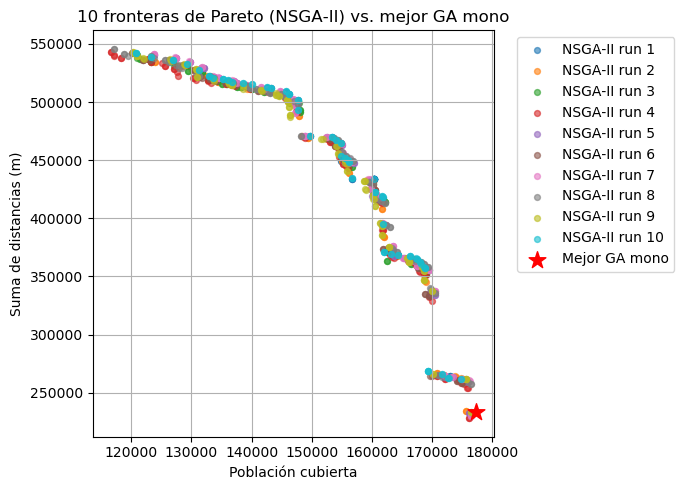

In [36]:
# ╔═════════════════════════════════════════════════════╗
# ║  Gráfica de las 10 fronteras + mejor punto GA mono  ║
# ╚═════════════════════════════════════════════════════╝
plt.figure(figsize=(7,5))
for run in range(1, CONFIG['n_runs']+1):
    sub = df_pareto[df_pareto['Run']==run]
    plt.scatter(sub['Coverage'], sub['Dispersion'],
                s=18, alpha=0.6, label=f'NSGA‑II run {run}')

# Mejor punto GA mono
best = df_ga.loc[df_ga['FitnessMono'].idxmax()]
plt.scatter(best['Coverage'], best['Dispersion'],
            c='red', marker='*', s=160, label='Mejor GA mono')

plt.xlabel('Población cubierta')
plt.ylabel('Suma de distancias (m)')
plt.title('10 fronteras de Pareto (NSGA‑II) vs. mejor GA mono')
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


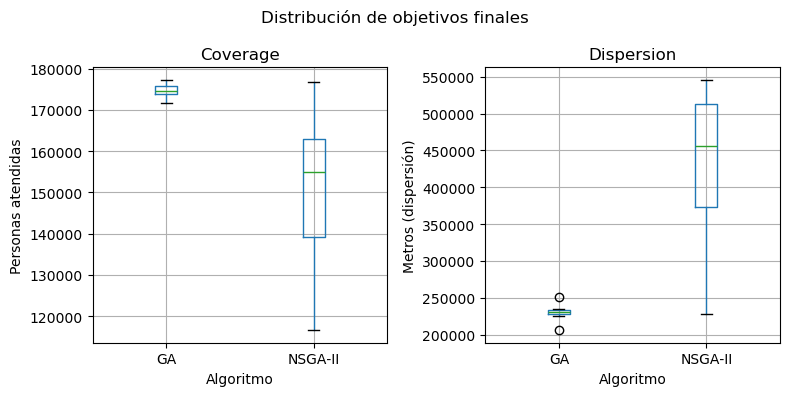

In [37]:
# ╔═════════════════════════════════════════════╗
# ║  DF con resultados finales de GA y NSGA‑II  ║
# ╚═════════════════════════════════════════════╝

ga_points   = df_ga[['Coverage','Dispersion']].assign(Algoritmo='GA')
nsga_points = df_pareto[['Coverage','Dispersion']].assign(Algoritmo='NSGA‑II')
df_box = pd.concat([ga_points, nsga_points], ignore_index=True)

fig, ax = plt.subplots(1,2, figsize=(8,4))
df_box.boxplot(column='Coverage', by='Algoritmo', ax=ax[0])
df_box.boxplot(column='Dispersion', by='Algoritmo', ax=ax[1])
ax[0].set_ylabel('Personas atendidas')
ax[1].set_ylabel('Metros (dispersión)')
plt.suptitle('Distribución de objetivos finales')
plt.tight_layout()
plt.show()


In [ ]:
# ╔══════════════════════════════════════════╗
# ║  Mapa de puntos de Supermercados [Mono]  ║
# ╚══════════════════════════════════════════╝
best_row     = df_ga.loc[df_ga['FitnessMono'].idxmax()]
best_chrom   = best_row['Chromosome']
lat_c, lon_c = coords.mean(axis=0)
m = folium.Map(location=[lat_c, lon_c], zoom_start=13)

# Todos los candidatos
for lat, lon in coords:
    folium.CircleMarker([lat, lon], radius=3, color='gray',
                        fill=True, fill_opacity=0.3).add_to(m)

# Marcar los 10 seleccionados
for idx in best_chrom:
    lat, lon = coords[idx]
    folium.Marker([lat, lon],
                  tooltip=f'{ids[idx]}<br>{desc[idx]}',
                  icon=folium.Icon(color='red', icon='shopping-cart', prefix='fa')
                 ).add_to(m)

m.save('visualizaciones/mapa_mejor_GA.html')
m

In [ ]:
# ╔═════════════════════════════════════════════════════════╗
# ║  Mapa de puntos de Supermercados [NSGA Máx distancias]  ║
# ╚═════════════════════════════════════════════════════════╝
best_nsga_row   = df_pareto.loc[df_pareto['Dispersion'].idxmax()]
best_nsga_chrom = best_nsga_row['Chromosome']
mapa_nsga = folium.Map(location=[lat_c, lon_c], zoom_start=13)

# Candidatos
for lat, lon in coords:
    folium.CircleMarker([lat, lon], radius=3, color='gray',
                        fill=True, fill_opacity=0.3).add_to(mapa_nsga)

# Marcar los 10 seleccionados
for idx in best_nsga_chrom:
    lat, lon = coords[idx]
    folium.Marker([lat, lon],
                  tooltip=f'{ids[idx]}<br>{desc[idx]}',
                  icon=folium.Icon(color='blue', icon='shopping-cart', prefix='fa')
                 ).add_to(mapa_nsga)

mapa_nsga.save('visualizaciones/mapa_NSLA_max_dist.html')
mapa_nsga

In [ ]:
# ╔═════════════════════════════════════════════════╗
# ║  Mapa de puntos de Supermercados [Punto Medio]  ║
# ╚═════════════════════════════════════════════════╝
min_cov, max_cov = df_pareto['Coverage'].min(), df_pareto['Coverage'].max()
min_disp, max_disp = df_pareto['Dispersion'].min(), df_pareto['Dispersion'].max()
midpoint = np.array([(min_cov+max_cov)/2, (min_disp+max_disp)/2])

points = df_pareto[['Coverage','Dispersion']].values
dists = np.linalg.norm(points - midpoint, axis=1)
best_idx = np.argmin(dists)
best_compromise = df_pareto.iloc[best_idx]
comp_chrom = best_compromise['Chromosome']

lat_c, lon_c = coords.mean(axis=0)
mapa_comp = folium.Map(location=[lat_c, lon_c], zoom_start=13)

# Todos los candidatos
for lat, lon in coords:
    folium.CircleMarker([lat, lon],
                        radius=3, color='gray',
                        fill=True, fill_opacity=0.3).add_to(mapa_comp)

# Marcar los 10 elegidos en el punto "medio"
for idx in comp_chrom:
    lat, lon = coords[idx]
    folium.Marker([lat, lon],
                  tooltip=f'{ids[idx]}<br>{desc[idx]}',
                  icon=folium.Icon(color='black',
                                   icon='shopping-cart',
                                   prefix='fa')
                 ).add_to(mapa_comp)

mapa_comp.save('visualizaciones/mapa_punto_medio.html')
mapa_comp

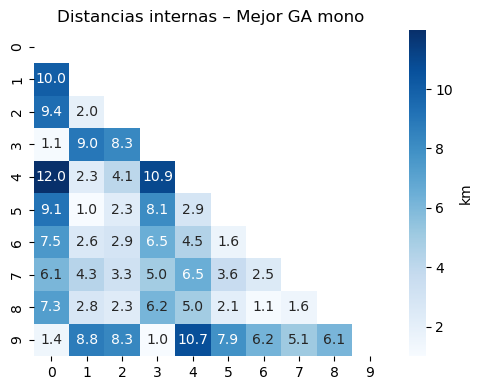

In [40]:
# ╔═══════════════════╗
# ║  Heatmap GA Mono  ║
# ╚═══════════════════╝
heatmap_distances(best_chrom,
                  'Distancias internas – Mejor GA mono')

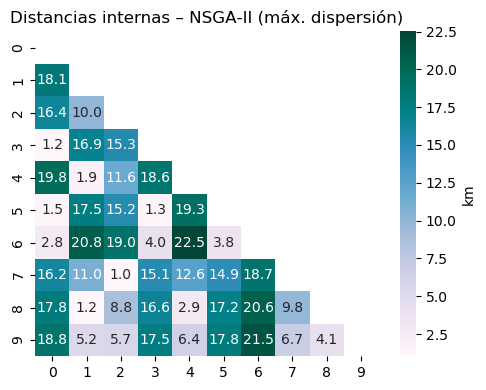

In [41]:
# ╔═════════════════════════════════════╗
# ║  Heatmap NSGA‑II (Máx. dispersión)  ║
# ╚═════════════════════════════════════╝
heatmap_distances(best_nsga_chrom,
                  'Distancias internas – NSGA‑II (máx. dispersión)',
                  cmap='PuBuGn')

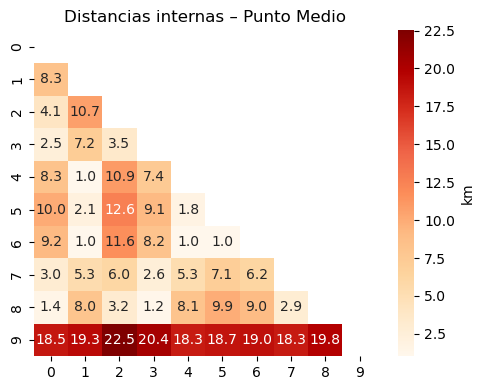

In [44]:
# ╔═════════════════════════════════╗
# ║  Heatmap NSGA‑II (Punto Medio)  ║
# ╚═════════════════════════════════╝
heatmap_distances(comp_chrom,
                  'Distancias internas – Punto Medio',
                  cmap='OrRd')